<a href="https://colab.research.google.com/github/dolmani38/concept_drift/blob/main/230423.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [75]:
import random
import os
def seed_everything(seed: int = 46):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    #tf.random.set_seed(seed)

# 준비
+ synthetic data를 만든다.
+ 해당 data는 importance가 시간에 따라 변화 된다.
+ 이때, 성능의 감소를 정량적으로 측정하고
+ Bucket을 고려한 몇개의 모델을 적용한다. 

## synthetic data의 생성

+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature는 가변 importance

In [76]:
data_size = 40000
cor = [2.5, 2.0, 1.5 , 1.0, 0.5]

In [151]:
y= (np.random.normal(0.5,0.5,100) > 0.5).astype(int)
sum(y)

45

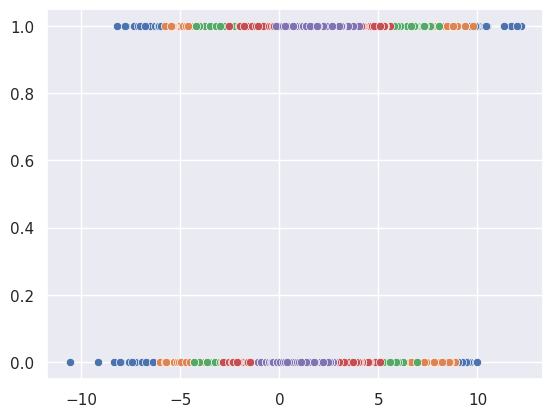

In [152]:
seed_everything()
#y= np.random.normal(1,2,data_size)
y= (np.random.normal(0.5,0.5,data_size) > 0.5).astype(int)
x = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x[:,ix] = y + np.random.normal(1,cor_,data_size)
    sns.scatterplot(x=x[:,ix],y=y)

<Axes: >

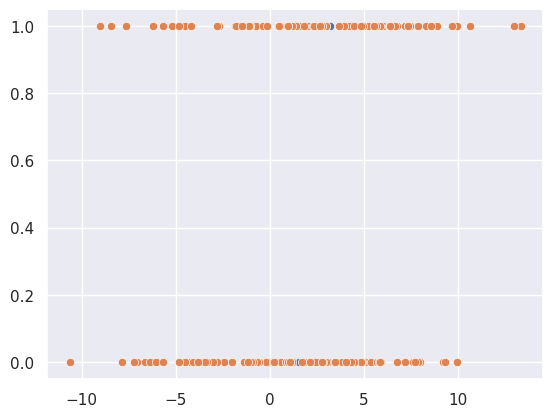

In [153]:
seed_everything(100)

for i in range(400):
    s = i*100
    #x[s:s+100,3] = y[s:s+100] + np.random.normal(1,5-(i/100),100)    
    x[s:s+100,4] = y[s:s+100] + np.random.normal(1,0.5+(i/100),100)
    #x[s:s+100,5] = i
sns.scatterplot(x=x[0:200,4],y=y[0:200])
sns.scatterplot(x=x[39800:40000,4],y=y[39800:40000])

## Mutual Information의 측정

In [154]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [155]:
columns=['x0','x1','x2','x3','z0']
X = pd.DataFrame(x,columns=columns)
mi_scores = make_mi_scores(X, y, discrete_features="auto")
print(mi_scores)

x3    0.111433
x2    0.055735
x1    0.033196
z0    0.027068
x0    0.018038
Name: MI Scores, dtype: float64


### Bucket 별 MI 측정

+ Bucket을 10, 50, 100 으로 나눠서

Bucket size 10


100%|██████████| 10/10 [00:01<00:00,  9.66it/s]


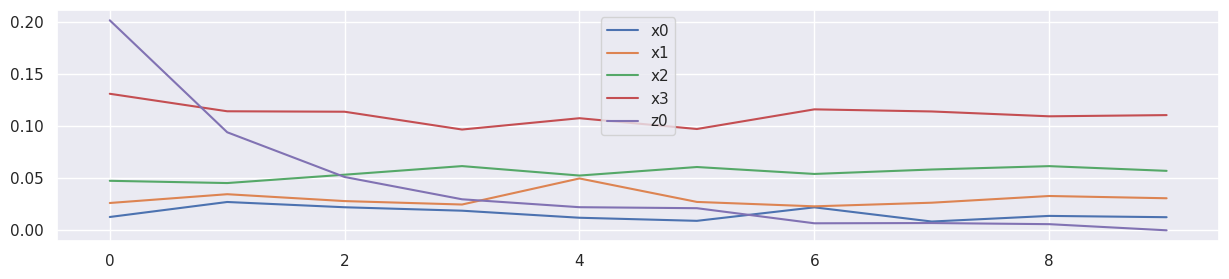

Bucket size 50


100%|██████████| 50/50 [00:01<00:00, 37.23it/s]


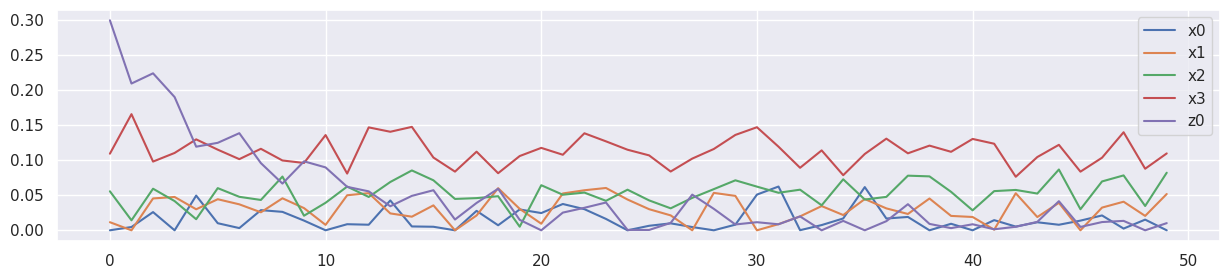

Bucket size 100


100%|██████████| 100/100 [00:01<00:00, 68.04it/s]


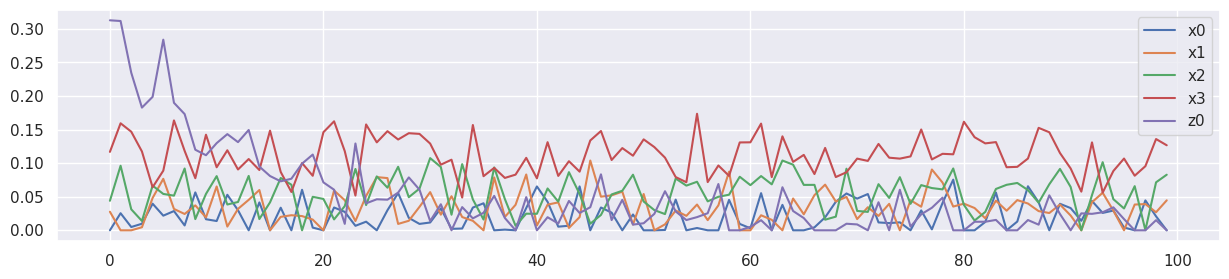

Bucket size 200


100%|██████████| 200/200 [00:02<00:00, 89.04it/s]


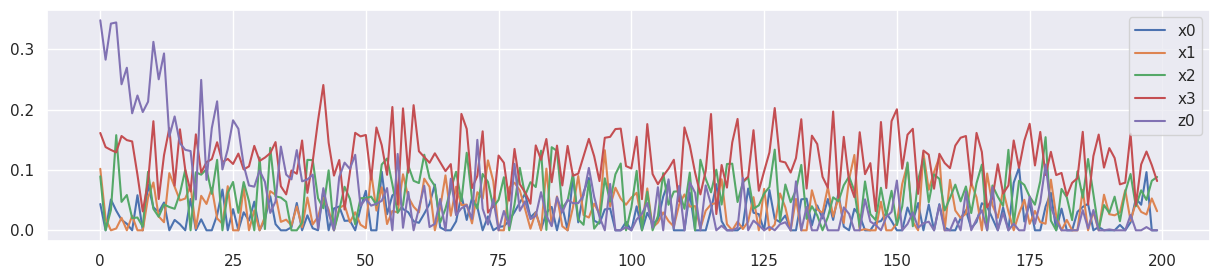

In [156]:
from tqdm import tqdm

bucket_size_array=[10,50,100,200]

for bucket_size in bucket_size_array:
    #bucket_size = 10
    print('Bucket size',bucket_size)
    MIS = {}
    for col in columns:
        MIS[col] = []

    step_size = int(x.shape[0]/bucket_size)
    for bk in tqdm(range(bucket_size)):
        #print(bk,step_size)
        mi_scores = make_mi_scores(X[bk*step_size:bk*step_size+step_size], y[bk*step_size:bk*step_size+step_size], discrete_features="auto")
        for col in columns:
            MIS[col].append(mi_scores[col]) 

    df_mis = pd.DataFrame(MIS)
    df_mis.plot(figsize=(15,3))
    plt.show()

+ 상기 실험에서, z0의 MI는 bucket의 증가에 따라, 낮아지는 것을 확인할 수 있다.

# Deep architecture에 의한 y의 추정 실험

+ 2000개를 학습하고, 이후 38000개를 추정한다.

## 학습데이터, 2000개 내 bucket 20개의 importance 변화

100%|██████████| 20/20 [00:00<00:00, 62.24it/s]


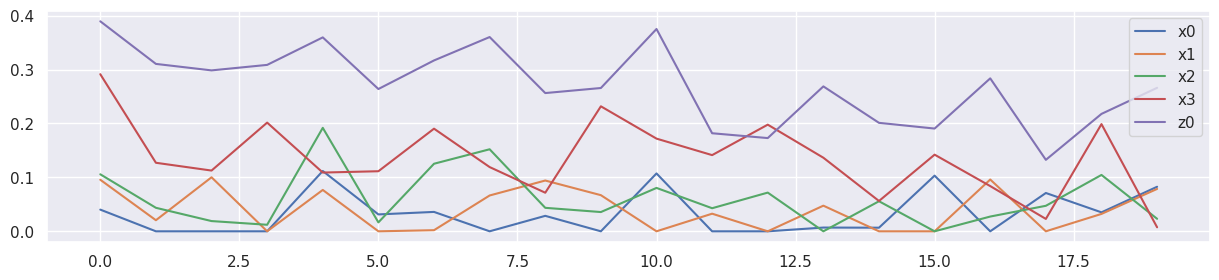

In [157]:
MIS = {}
for col in columns:
    MIS[col] = []
        
for bk in tqdm(range(20)):
    bx = X[bk*100:(bk+1)*100]
    by = y[bk*100:(bk+1)*100]
    mi_scores = make_mi_scores(bx, by, discrete_features="auto")
    for col in columns:
        MIS[col].append(mi_scores[col]) 

df_mis = pd.DataFrame(MIS)
df_mis.plot(figsize=(15,3))
plt.show()

## feature 5개를 모두 포함한 학습

100%|██████████| 1000/1000 [00:21<00:00, 45.76it/s]


MSE: 0.43
RMSE: 0.66


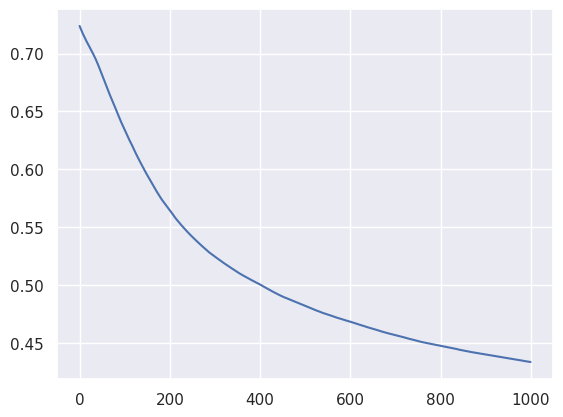

In [173]:
import copy
import torch.optim as optim
 
seed_everything()

# Convert to 2D PyTorch tensors
X_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32)
y_train = torch.tensor(y[0:1800], dtype=torch.float32).reshape(-1, 1)

X_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32)
y_test = torch.tensor(y[1800:2000], dtype=torch.float32).reshape(-1, 1)
 
# Define the model
model = nn.Sequential(
    nn.Linear(5, 20),
    nn.ReLU(),
    nn.Linear(20, 5),
    nn.ReLU(),
    nn.Linear(5, 1),
    nn.Sigmoid()
)
 
# loss function and optimizer
loss_fn = nn.BCELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
n_epochs = 1000   # number of epochs to run
batch_size = 100  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in tqdm(range(n_epochs)):
    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

+ F1 측정

In [174]:
from sklearn.metrics import r2_score,precision_recall_fscore_support,f1_score
predicted_y = model(X_test)
f1 = f1_score(y_test,(predicted_y.data.numpy()> 0.5).astype(float))
print('F1 score',f1)

F1 score 0.7674418604651162


+ 2000~40000까지의 R-squared score 측정 

100%|██████████| 190/190 [00:00<00:00, 526.77it/s]


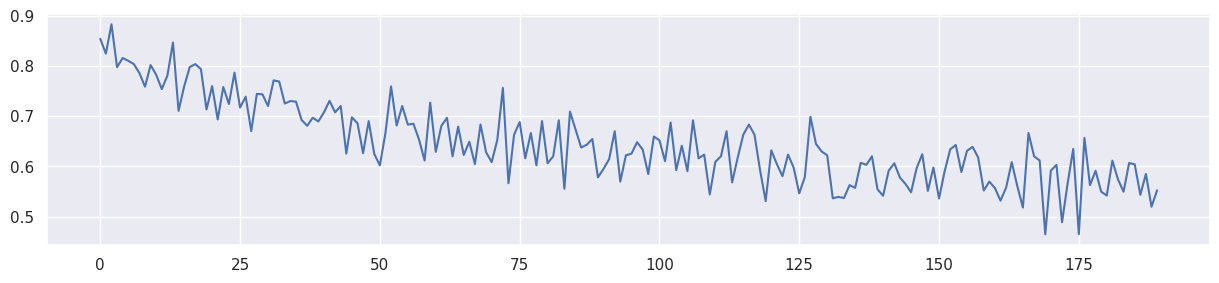

Mean F1 for all data: 0.6468086328124149


In [178]:
XT = X[2000:][['x0','x1','x2','x3','z0']]
yT = y[2000:]

bucket_size_array=[200]

for bucket_size in bucket_size_array:
    bucket_count = int(XT.shape[0]/bucket_size)
    f1s = []
    for bk in tqdm(range(bucket_count)):
        tmp_x = torch.tensor(XT[bk*bucket_count:bk*bucket_count+bucket_count].values, dtype=torch.float32)
        predicted_y = model(tmp_x)
        predicted_y = (predicted_y.data.numpy()> 0.5).astype(float)
        f1 = f1_score(yT[bk*bucket_count:bk*bucket_count+bucket_count],predicted_y)
        f1s.append(f1)
    plt.figure(figsize=(15,3))
    plt.plot(f1s)
    plt.show()
print('Mean F1 for all data:',np.mean(f1s))

## feature 5개 + bucket(B) = feature 6개를 학습

In [179]:
# bucket 하나의 크기는 100
# 2000개의 학습데이터에는 20개의 bucket이 있음.
# 학습데이터 100개당 +1의 bucket count를 증가 시킴
X['b'] = [int(b) for b in X.index.values/100]
X

,x0,x1,x2,x3,z0,b
0,2.386389,-0.228245,2.267412,0.829766,1.125117,0
1,0.877120,2.475075,2.604616,2.912580,2.171340,0
2,1.742247,4.905317,4.183683,1.674961,2.576518,0
3,4.290690,-1.048662,1.040967,1.554136,0.873782,0
4,3.423370,3.837573,1.351299,1.678259,2.490660,0
...,...,...,...,...,...,...
39995,-0.524797,-1.619554,1.878721,2.238780,-1.177338,399
39996,1.115868,-1.035412,1.540145,2.140368,4.045168,399
39997,-0.617842,2.989980,2.549017,1.799280,1.785665,399
39998,2.018777,-1.647812,-1.653163,2.608982,9.291351,399


100%|██████████| 1000/1000 [00:22<00:00, 45.12it/s]


MSE: 0.38
RMSE: 0.62


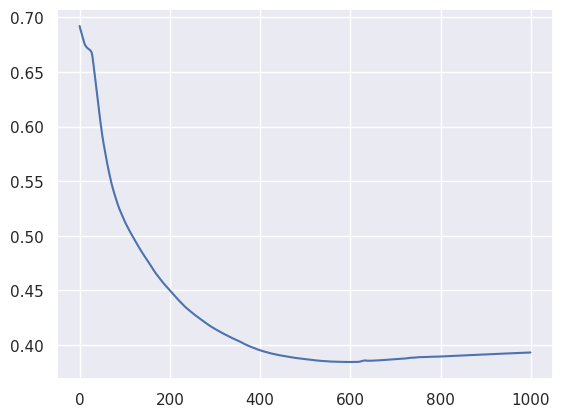

In [180]:
seed_everything()

X_train = torch.tensor(X[0:1800].values, dtype=torch.float32)
y_train = torch.tensor(y[0:1800], dtype=torch.float32).reshape(-1, 1)

X_test = torch.tensor(X[1800:2000].values, dtype=torch.float32)
y_test = torch.tensor(y[1800:2000], dtype=torch.float32).reshape(-1, 1)
 
# Define the model
model = nn.Sequential(
    nn.Linear(6, 24),
    nn.ReLU(),
    nn.Linear(24, 6),
    nn.ReLU(),
    nn.Linear(6, 1),
    nn.Sigmoid()
)
 
# loss function and optimizer
loss_fn = nn.BCELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
n_epochs = 1000   # number of epochs to run
batch_size = 100  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in tqdm(range(n_epochs)):
    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [181]:
predicted_y = model(X_test)
f1 = f1_score(y_test,(predicted_y.data.numpy()> 0.5).astype(float))
print('F1 score',f1)

F1 score 0.7647058823529412


100%|██████████| 190/190 [00:00<00:00, 426.86it/s]


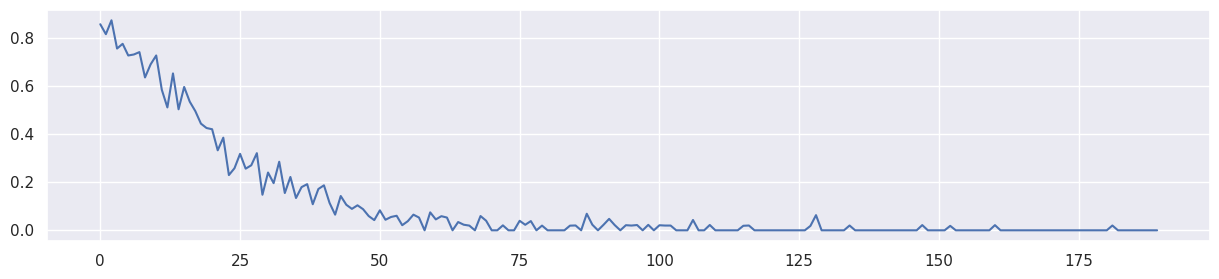

Mean F1 for all data: 0.10822752906057664


In [182]:
XT = X[2000:]
yT = y[2000:]

bucket_size_array=[200]

for bucket_size in bucket_size_array:
    bucket_count = int(XT.shape[0]/bucket_size)
    f1s = []
    for bk in tqdm(range(bucket_count)):
        tmp_x = torch.tensor(XT[bk*bucket_count:bk*bucket_count+bucket_count].values, dtype=torch.float32)
        predicted_y = model(tmp_x)
        predicted_y = (predicted_y.data.numpy()> 0.5).astype(float)
        f1 = f1_score(yT[bk*bucket_count:bk*bucket_count+bucket_count],predicted_y)
        f1s.append(f1)
    plt.figure(figsize=(15,3))
    plt.plot(f1s)
    plt.show()
print('Mean F1 for all data:',np.mean(f1s))

## z0를 빼고, 4개 feature로 학습

100%|██████████| 1000/1000 [00:21<00:00, 47.50it/s]


MSE: 0.19
RMSE: 0.44


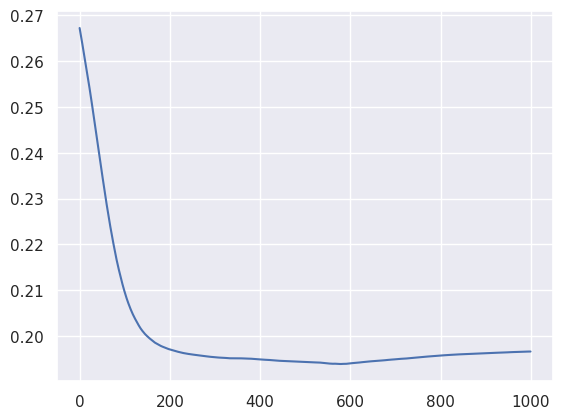

In [184]:
seed_everything()

X_train = torch.tensor(X[0:1800][['x0','x1','x2','x3']].values, dtype=torch.float32)
y_train = torch.tensor(y[0:1800], dtype=torch.float32).reshape(-1, 1)

X_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3']].values, dtype=torch.float32)
y_test = torch.tensor(y[1800:2000], dtype=torch.float32).reshape(-1, 1)
 
# Define the model
model = nn.Sequential(
    nn.Linear(4, 16),
    nn.ReLU(),
    nn.Linear(16, 4),
    nn.ReLU(),
    nn.Linear(4, 1),
    nn.Sigmoid()
)
 
# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
n_epochs = 1000   # number of epochs to run
batch_size = 100 # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in tqdm(range(n_epochs)):
    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [185]:
predicted_y = model(X_test)
f1 = f1_score(y_test,(predicted_y.data.numpy()> 0.5).astype(float))
print('F1 score',f1)

F1 score 0.6994535519125683


100%|██████████| 190/190 [00:00<00:00, 352.22it/s]


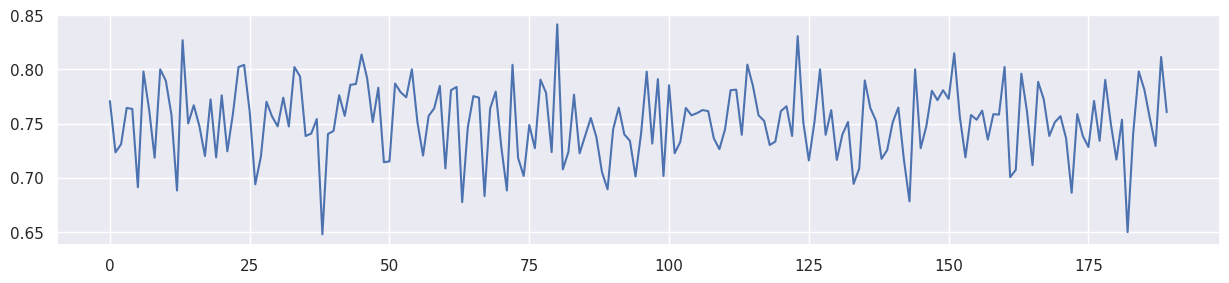

Mean F1 for all data: 0.7518409807889512


In [186]:
XT = X[2000:][['x0','x1','x2','x3']]
yT = y[2000:]

bucket_size_array=[200]

for bucket_size in bucket_size_array:
    bucket_count = int(XT.shape[0]/bucket_size)
    f1s = []
    for bk in tqdm(range(bucket_count)):
        tmp_x = torch.tensor(XT[bk*bucket_count:bk*bucket_count+bucket_count].values, dtype=torch.float32)
        predicted_y = model(tmp_x)
        predicted_y = (predicted_y.data.numpy()> 0.5).astype(float)
        f1 = f1_score(yT[bk*bucket_count:bk*bucket_count+bucket_count],predicted_y)
        f1s.append(f1)
    plt.figure(figsize=(15,3))
    plt.plot(f1s)
    plt.show()
print('Mean F1 for all data:',np.mean(f1s))  

+ 위에서 보면.... 학습과정에서, 현재는 학습에 효과가 있지만 향후 잠재적으로 성능을 저해할 수 있는 feature를 탐지하여 이의 효과를 경감 또는 (보정) 할 수 있는 학습 방법을 찾아야 하는 것!!!

## RF-Train의 적용

+ 위의 데이터에서, sensitive attribute는 z0에 대당된다.
+ 따라서, MI(y^|z0) = 0 이되어야 하고,
+ Fairness discriminator에서는  Y^과 z0의 loss가 커야 한다! 즉, 최대한 상관 없어야 한다.
+ OK, 일단 이렇게 구성해 본다!

In [93]:
!git clone https://github.com/yuji-roh/fr-train.git

Cloning into 'fr-train'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 31 (delta 9), reused 4 (delta 0), pack-reused 0
Unpacking objects: 100% (31/31), 168.32 KiB | 2.90 MiB/s, done.


In [94]:
%cd fr-train
!pwd

/content/fr-train/fr-train/fr-train
/content/fr-train/fr-train/fr-train


In [95]:
import sys, os
import math

from torch.autograd import Variable
from argparse import Namespace
#from FRTrain_arch import Generator, DiscriminatorF, DiscriminatorR, weights_init_normal, test_model
from FRTrain_arch import weights_init_normal, test_model
import warnings
warnings.filterwarnings("ignore")

+ Generator의 구현 = 위에서 feature 5개의 model과 동일
+ DiscriminatorF = Y^과 z0가 같아지지 않게 학습 ??

In [187]:

def test_model(model_, tX, ty, s1):
    """Tests the performance of a model.

    Args:
        model_: A model to test.
        X: Input features of test data.
        y: True label (1-D) of test data.
        s1: Sensitive attribute (1-D) of test data.

    Returns:
        The test accuracy and disparate impact of the model.
    """
    
    model_.eval()
    
    y_hat = model_(tX)
    y_hat = (y_hat.data.numpy()> 0.5).astype(float)

    print('ty',ty.shape)
    print('y_hat',y_hat.shape)
    
    f1 = f1_score(ty,y_hat)
    #print('R-squared score',r2)
    mi_scores = make_mi_scores(pd.DataFrame(tX[:,4],columns=['z0']), y_hat, discrete_features="auto")
    mi = mi_scores['z0']
    print("Test f1 score: {}".format(f1))
    print("Mutual Information y_hat^,z0 = {:.3f}".format(mi))
#     min_eo = min(Pr_y_hat_1_y_1_z_0, Pr_y_hat_1_y_1_z_1)
#     max_eo = max(Pr_y_hat_1_y_1_z_0, Pr_y_hat_1_y_1_z_1)
#     print("Equal Opportunity ratio = {:.3f}".format(min_eo/max_eo))
    return f1, mi

In [194]:
# Define the Generator
class Generator(nn.Module):
    """FR-Train generator (classifier).
    
    This class is for defining the structure of FR-Train generator (classifier). 
    (ref: FR-Train paper, Section 3)

    Attributes:
        model: A model consisting of torch components.
    """
    
    def __init__(self):
        """Initializes Generator with torch components."""
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(5, 20),
            nn.ReLU(),
            nn.Linear(20, 5),
            nn.ReLU(),
            nn.Linear(5, 1),
            nn.Sigmoid()
        )

    def forward(self, input_data):
        """Defines a forward operation of the model.
        
        Args: 
            input_data: The input data.
            
        Returns:
            The predicted label (y_hat) for the given input data.
        """
        
        output = self.model(input_data)
        return output

# DiscriminatorF
# regression, Y^과 z0가 같아지지 않게 학습...??? (이거 쫌 아리까리!)
class DiscriminatorF(nn.Module):
    """FR-Train fairness discriminator.
    
    This class is for defining structure of FR-Train fairness discriminator. 
    (ref: FR-Train paper, Section 3)

    Attributes:
        model: A model consisting of torch components.
    """
    
    def __init__(self):
        """Initializes DiscriminatorF with torch components."""
        
        super(DiscriminatorF, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(2, 8),
            nn.Linear(8, 1),
            nn.Sigmoid()            
        )

    def forward(self, x1, x2):
        """Defines a forward operation of the model.
        
        Args: 
            input_data: The input data.
            
        Returns:
            The predicted sensitive attribute for the given input data.
        """
        
        predicted_z = self.model(torch.cat((x1, x2), 1))
        return predicted_z
    

In [189]:
# 본래의 FR-Train에서, Robustness Discriminator를 삭제 하였으므로,  val_tensors, lambda_r 를 삭제 한다.

def train_model(train_tensors, test_tensors, train_opt, lambda_f, seed):
    """
      Trains FR-Train by using the classes in FRTrain_arch.py.
      
      Args:
        train_tensors: Training data.
        test_tensors: Test data.
        train_opt: Options for the training. It currently contains size of validation set, 
                number of epochs, generator/discriminator update ratio, and learning rates.
        lambda_f: The tuning knob for L_2 (ref: FR-Train paper, Section 3.3).
        seed: An integer value for specifying torch random seed.
        
      Returns:
        Information about the tuning knobs (lambda_f),
        the test accuracy of the trained model, and disparate impact of the trained model.
    """
    
    XS_train = train_tensors.XS_train
    y_train = train_tensors.y_train
    s1_train = train_tensors.s1_train
    
    XS_test = test_tensors.XS_test
    y_test = test_tensors.y_test
    s1_test = test_tensors.s1_test
    
    # Saves return values here
    #test_result = [] 
    
    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch
    

    # The loss values of each component will be saved in the following lists. 
    # We can draw epoch-loss graph by the following lists, if necessary.
    g_losses =[]
    d_f_losses = []

    bce_loss = nn.BCELoss()
    #mse_loss = nn.MSELoss()  # mean square error

    # Initializes generator and discriminator
    generator = Generator()
    discriminator_F = DiscriminatorF()

    # Initializes weights
    torch.manual_seed(seed)
    generator.apply(weights_init_normal)
    discriminator_F.apply(weights_init_normal)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=train_opt.lr_g)
    optimizer_D_F = torch.optim.SGD(discriminator_F.parameters(), lr=train_opt.lr_f)

    train_len = XS_train.shape[0]

    for epoch in range(n_epochs):

        # -------------------
        #  Forwards Generator
        # -------------------
        optimizer_G.zero_grad()
        gen_y = generator(XS_train).reshape(-1,1)
        g_loss = bce_loss(gen_y, y_train.reshape(-1,1))
        g_loss.backward()
        g_losses.append(g_loss)
        optimizer_G.step()

        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, g_losses[-1])
                )

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    f1, mi = test_model(generator, XS_test, y_test, s1_test)
    #test_result.append([lambda_f, tmp[0].item(), tmp[1]])

    return f1, mi, generator

In [216]:
# 본래의 FR-Train에서, Robustness Discriminator를 삭제 하였으므로,  val_tensors, lambda_r 를 삭제 한다.

def train_model2(train_tensors, test_tensors, train_opt, lambda_f, seed):
    """
      Trains FR-Train by using the classes in FRTrain_arch.py.
      
      Args:
        train_tensors: Training data.
        test_tensors: Test data.
        train_opt: Options for the training. It currently contains size of validation set, 
                number of epochs, generator/discriminator update ratio, and learning rates.
        lambda_f: The tuning knob for L_2 (ref: FR-Train paper, Section 3.3).
        seed: An integer value for specifying torch random seed.
        
      Returns:
        Information about the tuning knobs (lambda_f),
        the test accuracy of the trained model, and disparate impact of the trained model.
    """
    
    XS_train = train_tensors.XS_train
    y_train = train_tensors.y_train
    s1_train = train_tensors.s1_train
    
    XS_test = test_tensors.XS_test
    y_test = test_tensors.y_test
    s1_test = test_tensors.s1_test
    
    # Saves return values here
    #test_result = [] 
    
    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch
    

    # The loss values of each component will be saved in the following lists. 
    # We can draw epoch-loss graph by the following lists, if necessary.
    g_losses =[]
    d_f_losses = []

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss()  # mean square error

    # Initializes generator and discriminator
    generator = Generator()
    discriminator_F = DiscriminatorF()

    # Initializes weights
    torch.manual_seed(seed)
    generator.apply(weights_init_normal)
    discriminator_F.apply(weights_init_normal)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=train_opt.lr_g)
    optimizer_D_F = torch.optim.Adam(discriminator_F.parameters(), lr=train_opt.lr_f)

    train_len = XS_train.shape[0]

    real_label = 1
    fake_label = 0

    rlabel = torch.full((train_len,), real_label, dtype=torch.float32).reshape(-1,1)
    flabel = torch.full((train_len,), fake_label, dtype=torch.float32).reshape(-1,1)
    for epoch in range(n_epochs):

        # -------------------
        #  Forwards Generator
        # -------------------
        optimizer_G.zero_grad()
        gen_y = generator(XS_train).reshape(-1,1)
        #g_loss = 0.000001*mse_loss(gen_y, y_train.reshape(-1,1))

        # -------------------------------
        #  Trains Fairness Discriminator
        # -------------------------------
        optimizer_D_F.zero_grad()
        # y과 z는 무관 (MI=0) 이면, True
        # y^과 z가 상관 (MI>0) 이면, False 로 정의 한다. 
        f_loss = bce_loss(discriminator_F(gen_y, s1_train.reshape(-1,1)),flabel)
        r_loss = bce_loss(discriminator_F(y_train.reshape(-1,1), s1_train.reshape(-1,1)),rlabel)
        d_f_loss =  (f_loss + r_loss) 
        #d_f_loss.backward()
        d_f_losses.append(d_f_loss)
        #optimizer_D_F.step()        
        
        #loss = (1-lambda_f) * g_loss - lambda_f * d_f_loss 

        # -------------------
        #  Update Generator
        # -------------------
        g_cost = 0.01 * bce_loss(gen_y, y_train.reshape(-1,1))
        #f_cost = bce_loss(discriminator_F(gen_y.detach(), s1_train.reshape(-1,1)),rlabel)
        g_loss = (1-lambda_f)*g_cost + lambda_f*d_f_loss
        g_losses.append(g_loss)
        g_loss.backward()
        optimizer_G.step()
        optimizer_D_F.step()    

        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [D_F loss: %f] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, d_f_losses[-1], g_losses[-1])
                )

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    f1,mi = test_model(generator, XS_test, y_test, s1_test)
    #test_result.append([lambda_f, tmp[0].item(), tmp[1]])

    return f1,mi,generator

In [190]:
def test_all_data(generator):

    XT = X[2000:][['x0','x1','x2','x3','z0']]
    yT = y[2000:]

    bucket_size_array=[200]

    for bucket_size in bucket_size_array:
        bucket_count = int(XT.shape[0]/bucket_size)
        f1s = []
        for bk in tqdm(range(bucket_count)):
            tmp_x = torch.tensor(XT[bk*bucket_count:bk*bucket_count+bucket_count].values, dtype=torch.float32)
            predicted_y = generator(tmp_x)
            predicted_y = (predicted_y.data.numpy()> 0.5).astype(float)
            f1 = f1_score(yT[bk*bucket_count:bk*bucket_count+bucket_count],predicted_y)
            #r2 = r2_score(yT[bk*bucket_count:bk*bucket_count+bucket_count],predicted_y.detach().numpy())
            f1s.append(f1)
        plt.figure(figsize=(15,3))
        plt.plot(f1s)
        plt.show()

    print('Mean F1 for all data:',np.mean(f1s))   
    return f1s

[Lambda: 0.000000] [Epoch 0/4000] [G loss: 0.696792]
[Lambda: 0.000000] [Epoch 200/4000] [G loss: 0.681593]
[Lambda: 0.000000] [Epoch 400/4000] [G loss: 0.654076]
[Lambda: 0.000000] [Epoch 600/4000] [G loss: 0.625034]
[Lambda: 0.000000] [Epoch 800/4000] [G loss: 0.594989]
[Lambda: 0.000000] [Epoch 1000/4000] [G loss: 0.564511]
[Lambda: 0.000000] [Epoch 1200/4000] [G loss: 0.534539]
[Lambda: 0.000000] [Epoch 1400/4000] [G loss: 0.505423]
[Lambda: 0.000000] [Epoch 1600/4000] [G loss: 0.479087]
[Lambda: 0.000000] [Epoch 1800/4000] [G loss: 0.455296]
[Lambda: 0.000000] [Epoch 2000/4000] [G loss: 0.433303]
[Lambda: 0.000000] [Epoch 2200/4000] [G loss: 0.414752]
[Lambda: 0.000000] [Epoch 2400/4000] [G loss: 0.398290]
[Lambda: 0.000000] [Epoch 2600/4000] [G loss: 0.384013]
[Lambda: 0.000000] [Epoch 2800/4000] [G loss: 0.370682]
[Lambda: 0.000000] [Epoch 3000/4000] [G loss: 0.358292]
[Lambda: 0.000000] [Epoch 3200/4000] [G loss: 0.348798]
[Lambda: 0.000000] [Epoch 3400/4000] [G loss: 0.342150]

100%|██████████| 190/190 [00:00<00:00, 545.06it/s]


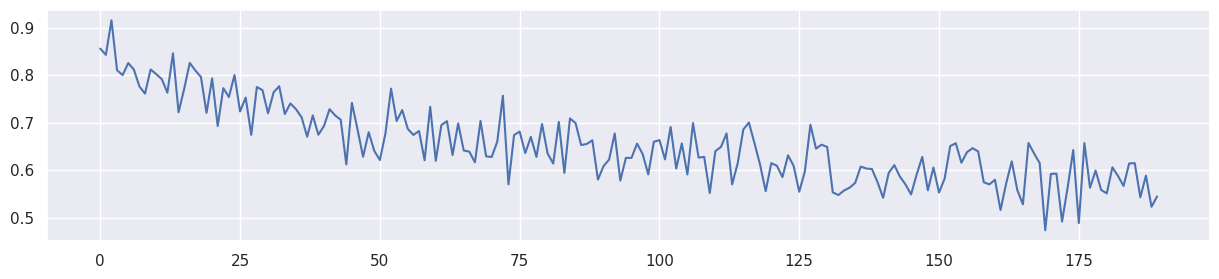

Mean F1 for all data: 0.6545377670182254
[Lambda: 0.100000] [Epoch 0/4000] [D_F loss: 1.386361] [G loss: 0.139263]
[Lambda: 0.100000] [Epoch 200/4000] [D_F loss: 1.376971] [G loss: 0.138314]
[Lambda: 0.100000] [Epoch 400/4000] [D_F loss: 1.295490] [G loss: 0.130194]
[Lambda: 0.100000] [Epoch 600/4000] [D_F loss: 1.144045] [G loss: 0.115201]
[Lambda: 0.100000] [Epoch 800/4000] [D_F loss: 1.028441] [G loss: 0.103888]
[Lambda: 0.100000] [Epoch 1000/4000] [D_F loss: 0.968206] [G loss: 0.098129]
[Lambda: 0.100000] [Epoch 1200/4000] [D_F loss: 0.938657] [G loss: 0.095413]
[Lambda: 0.100000] [Epoch 1400/4000] [D_F loss: 0.922977] [G loss: 0.094050]
[Lambda: 0.100000] [Epoch 1600/4000] [D_F loss: 0.913885] [G loss: 0.093315]
[Lambda: 0.100000] [Epoch 1800/4000] [D_F loss: 0.908212] [G loss: 0.092896]
[Lambda: 0.100000] [Epoch 2000/4000] [D_F loss: 0.904471] [G loss: 0.092647]
[Lambda: 0.100000] [Epoch 2200/4000] [D_F loss: 0.901901] [G loss: 0.092494]
[Lambda: 0.100000] [Epoch 2400/4000] [D_F 

100%|██████████| 190/190 [00:00<00:00, 548.01it/s]


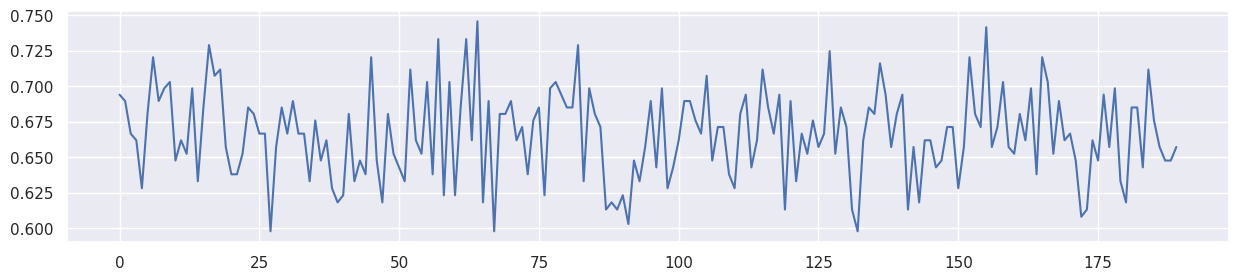

Mean F1 for all data: 0.6660083586974344
[Lambda: 0.200000] [Epoch 0/4000] [D_F loss: 1.386361] [G loss: 0.277830]
[Lambda: 0.200000] [Epoch 200/4000] [D_F loss: 1.377034] [G loss: 0.275956]
[Lambda: 0.200000] [Epoch 400/4000] [D_F loss: 1.294637] [G loss: 0.259503]
[Lambda: 0.200000] [Epoch 600/4000] [D_F loss: 1.142146] [G loss: 0.229141]
[Lambda: 0.200000] [Epoch 800/4000] [D_F loss: 1.026747] [G loss: 0.206283]
[Lambda: 0.200000] [Epoch 1000/4000] [D_F loss: 0.966737] [G loss: 0.194520]
[Lambda: 0.200000] [Epoch 1200/4000] [D_F loss: 0.937218] [G loss: 0.188834]
[Lambda: 0.200000] [Epoch 1400/4000] [D_F loss: 0.921487] [G loss: 0.185879]
[Lambda: 0.200000] [Epoch 1600/4000] [D_F loss: 0.912322] [G loss: 0.184214]
[Lambda: 0.200000] [Epoch 1800/4000] [D_F loss: 0.906569] [G loss: 0.183210]
[Lambda: 0.200000] [Epoch 2000/4000] [D_F loss: 0.902743] [G loss: 0.182575]
[Lambda: 0.200000] [Epoch 2200/4000] [D_F loss: 0.900082] [G loss: 0.182158]
[Lambda: 0.200000] [Epoch 2400/4000] [D_F 

100%|██████████| 190/190 [00:00<00:00, 529.88it/s]


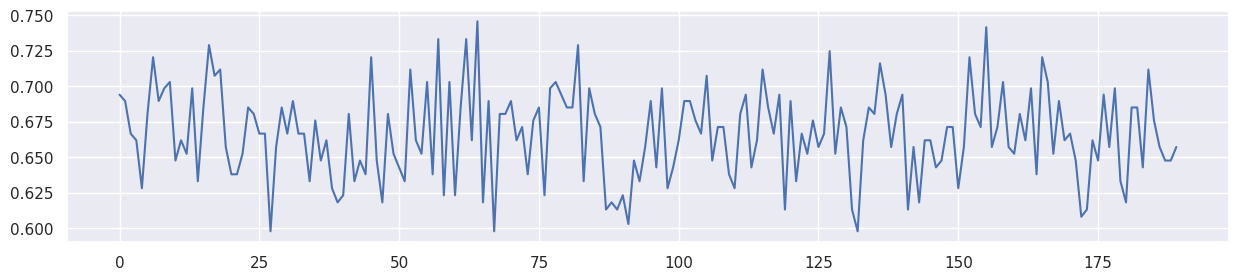

Mean F1 for all data: 0.6660083586974344
[Lambda: 0.300000] [Epoch 0/4000] [D_F loss: 1.386361] [G loss: 0.416396]
[Lambda: 0.300000] [Epoch 200/4000] [D_F loss: 1.377058] [G loss: 0.413599]
[Lambda: 0.300000] [Epoch 400/4000] [D_F loss: 1.294197] [G loss: 0.388763]
[Lambda: 0.300000] [Epoch 600/4000] [D_F loss: 1.141233] [G loss: 0.342994]
[Lambda: 0.300000] [Epoch 800/4000] [D_F loss: 1.026042] [G loss: 0.308632]
[Lambda: 0.300000] [Epoch 1000/4000] [D_F loss: 0.966169] [G loss: 0.290880]
[Lambda: 0.300000] [Epoch 1200/4000] [D_F loss: 0.936688] [G loss: 0.282228]
[Lambda: 0.300000] [Epoch 1400/4000] [D_F loss: 0.920959] [G loss: 0.277679]
[Lambda: 0.300000] [Epoch 1600/4000] [D_F loss: 0.911785] [G loss: 0.275077]
[Lambda: 0.300000] [Epoch 1800/4000] [D_F loss: 0.906018] [G loss: 0.273481]
[Lambda: 0.300000] [Epoch 2000/4000] [D_F loss: 0.902178] [G loss: 0.272449]
[Lambda: 0.300000] [Epoch 2200/4000] [D_F loss: 0.899497] [G loss: 0.271753]
[Lambda: 0.300000] [Epoch 2400/4000] [D_F 

100%|██████████| 190/190 [00:00<00:00, 484.46it/s]


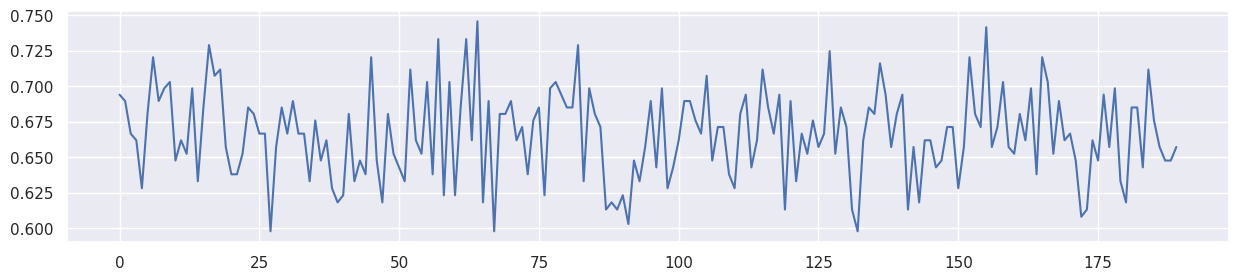

Mean F1 for all data: 0.6660083586974344


,lambda,test_f1,init_f1,mean_f1,last_f1,"MI(y^,z)"
0,0.0,0.786517,0.855769,0.654538,0.544444,3.184827e-01
1,0.1,0.601399,0.694158,0.666008,0.657244,8.881784e-16
2,0.2,0.601399,0.694158,0.666008,0.657244,8.881784e-16
3,0.3,0.601399,0.694158,0.666008,0.657244,8.881784e-16


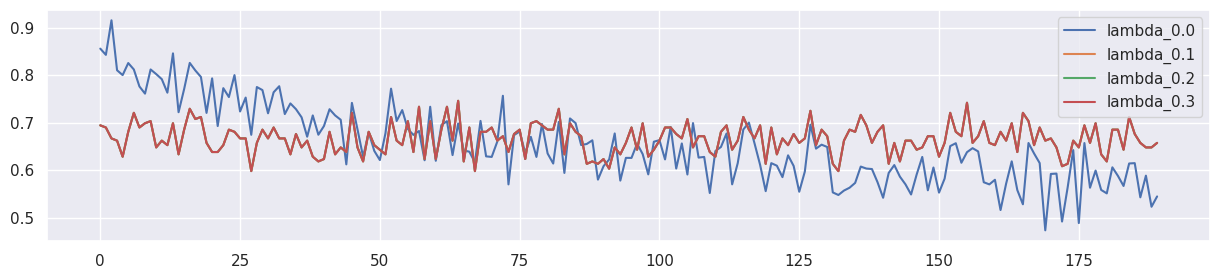

In [215]:
seed_everything()

train_result = []
train_tensors = Namespace(XS_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                          y_train = torch.tensor(y[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                         y_test = torch.tensor(y[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)
seed = 1

#lambda_f_set = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] # Lambda value for the fairness discriminator of FR-Train.
lambda_f_set = [0.0, 0.1, 0.2, 0.3] # Lambda value for the fairness discriminator of FR-Train.

result_table = {}
result_table2 = {}
result_table2['lambda']=[]
result_table2['test_f1']=[]
result_table2['init_f1']=[]
result_table2['mean_f1']=[]
result_table2['last_f1']=[]
result_table2['MI(y^,z)']=[]

for lambda_f in lambda_f_set:
    if lambda_f == 0.0:
        f1,mi,last_generator= train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed)
        result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator)
    else:
        f1,mi,last_generator= train_model2(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed)
        result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator)

    result_table2['lambda'].append(lambda_f)
    result_table2['test_f1'].append(f1)
    result_table2['init_f1'].append(result_table[f'lambda_{lambda_f}'][0])
    result_table2['mean_f1'].append(np.mean(result_table[f'lambda_{lambda_f}']))
    result_table2['last_f1'].append(result_table[f'lambda_{lambda_f}'][-1])
    result_table2['MI(y^,z)'].append(mi)

result_df = pd.DataFrame(result_table)
result_df.plot(figsize=(15,3))

result2_df = pd.DataFrame(result_table2)
result2_df

## MINE를 통해 I(y^,z) 측정

In [102]:
y_train.data.numpy()

array([[2.1697516 ],
       [3.4623914 ],
       [2.6438005 ],
       ...,
       [1.714063  ],
       [0.37184638],
       [0.9455982 ]], dtype=float32)

(40000, 5)
(40000,)


100%|██████████| 300/300 [00:00<00:00, 453.42it/s]

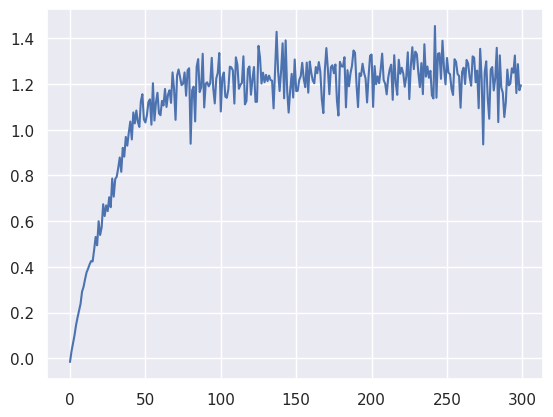

In [103]:
from tqdm import tqdm

H=20
n_epoch = 300
minibatch = 1000

x1 = X[0:1800][['z0']].values
y1 = y_train.data.numpy()

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, H)
        self.fc2 = nn.Linear(1, H)
        self.fc3 = nn.Linear(H, 1)

    def forward(self, x, y):
        h1 = F.relu(self.fc1(x)+self.fc2(y))
        h2 = self.fc3(h1)
        return h2  

model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

print(x.shape)
print(y.shape)
plot_loss = []
for epoch in tqdm(range(n_epoch)):
    s = np.random.choice(x1.shape[0],minibatch)
    x_sample = Variable(torch.from_numpy(x1[s].reshape(-1,1)).type(torch.FloatTensor), requires_grad = True)
    y_sample = Variable(torch.from_numpy(y1[s]).type(torch.FloatTensor), requires_grad = True)
    y_shuffle = Variable(torch.from_numpy(np.random.permutation(y1[s])).type(torch.FloatTensor), requires_grad = True)    
    ret = torch.mean(model(x_sample, y_sample)) - torch.log(torch.mean(torch.exp(model(x_sample, y_shuffle))))
    loss = - ret  # maximize
    model.zero_grad()
    loss.backward()
    optimizer.step()
    plot_loss.append(ret.data.numpy())


    #back_loss = loss

print('')

plot_loss = np.asarray(plot_loss)

plt.plot(plot_loss)

In [109]:
# 본래의 FR-Train에서, Robustness Discriminator를 삭제 하였으므로,  val_tensors, lambda_r 를 삭제 한다.

def train_model3(train_tensors, test_tensors, train_opt, lambda_f, seed):
    """
      Trains FR-Train by using the classes in FRTrain_arch.py.
      
      Args:
        train_tensors: Training data.
        test_tensors: Test data.
        train_opt: Options for the training. It currently contains size of validation set, 
                number of epochs, generator/discriminator update ratio, and learning rates.
        lambda_f: The tuning knob for L_2 (ref: FR-Train paper, Section 3.3).
        seed: An integer value for specifying torch random seed.
        
      Returns:
        Information about the tuning knobs (lambda_f),
        the test accuracy of the trained model, and disparate impact of the trained model.
    """
    
    XS_train = train_tensors.XS_train
    y_train = train_tensors.y_train
    s1_train = train_tensors.s1_train
    
    XS_test = test_tensors.XS_test
    y_test = test_tensors.y_test
    s1_test = test_tensors.s1_test
    
    # Saves return values here
    #test_result = [] 
    
    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch
    

    # The loss values of each component will be saved in the following lists. 
    # We can draw epoch-loss graph by the following lists, if necessary.
    g_losses =[]
    mi_losses = []

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss()  # mean square error

    # Initializes generator and discriminator
    generator = Generator()

    # Initializes weights
    torch.manual_seed(seed)
    generator.apply(weights_init_normal)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=train_opt.lr_g)

    train_len = XS_train.shape[0]

    mine = Net()
    optimizer = torch.optim.Adam(mine.parameters(), lr=0.01)
    minibatch = 1000

    for epoch in range(n_epochs):

        # -------------------
        #  Forwards Generator
        # -------------------
        optimizer_G.zero_grad()

        gen_y = generator(XS_train).reshape(-1,1)
        #g_loss = 0.000001*mse_loss(gen_y, y_train.reshape(-1,1))
        g_loss = 0.000001*mse_loss(gen_y, y_train.reshape(-1,1))
        g_losses.append(g_loss)
        # -------------------------------
        #  MINE
        # -------------------------------
        s = np.random.choice(XS_train.shape[0],minibatch)
        y1 = gen_y[s].data.numpy()
        x_sample = Variable(torch.from_numpy(s1_train[s].data.numpy().reshape(-1,1)).type(torch.FloatTensor), requires_grad = True)
        y_sample = Variable(torch.from_numpy(y1).type(torch.FloatTensor), requires_grad = True)
        y_shuffle = Variable(torch.from_numpy(np.random.permutation(y1)).type(torch.FloatTensor), requires_grad = True)    
        ret = torch.mean(mine(x_sample, y_sample)) - torch.log(torch.mean(torch.exp(mine(x_sample, y_shuffle))))
        mi_loss = - ret  # maximize
        mine.zero_grad()
        #loss.backward()
        

        mi_losses.append(mi_loss)
        #optimizer_D_F.step()
        
        loss = (1-lambda_f) * g_loss + lambda_f * mi_loss 

        loss.backward()
        optimizer_G.step()
        optimizer.step()

        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [mi loss: %f] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, mi_losses[-1], g_losses[-1])
                )

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    r2,mi = test_model(generator, XS_test, y_test, s1_test)
    #test_result.append([lambda_f, tmp[0].item(), tmp[1]])

    return r2,mi,generator

[Lambda: 0.000000] [Epoch 0/4000] [G loss: 5.344502]
[Lambda: 0.000000] [Epoch 200/4000] [G loss: 4.436438]
[Lambda: 0.000000] [Epoch 400/4000] [G loss: 3.057725]
[Lambda: 0.000000] [Epoch 600/4000] [G loss: 1.898989]
[Lambda: 0.000000] [Epoch 800/4000] [G loss: 1.257700]
[Lambda: 0.000000] [Epoch 1000/4000] [G loss: 0.927270]
[Lambda: 0.000000] [Epoch 1200/4000] [G loss: 0.699251]
[Lambda: 0.000000] [Epoch 1400/4000] [G loss: 0.566841]
[Lambda: 0.000000] [Epoch 1600/4000] [G loss: 0.492037]
[Lambda: 0.000000] [Epoch 1800/4000] [G loss: 0.442835]
[Lambda: 0.000000] [Epoch 2000/4000] [G loss: 0.405045]
[Lambda: 0.000000] [Epoch 2200/4000] [G loss: 0.373670]
[Lambda: 0.000000] [Epoch 2400/4000] [G loss: 0.346869]
[Lambda: 0.000000] [Epoch 2600/4000] [G loss: 0.324071]
[Lambda: 0.000000] [Epoch 2800/4000] [G loss: 0.304888]
[Lambda: 0.000000] [Epoch 3000/4000] [G loss: 0.288725]
[Lambda: 0.000000] [Epoch 3200/4000] [G loss: 0.274406]
[Lambda: 0.000000] [Epoch 3400/4000] [G loss: 0.261586]

100%|██████████| 190/190 [00:00<00:00, 1196.78it/s]


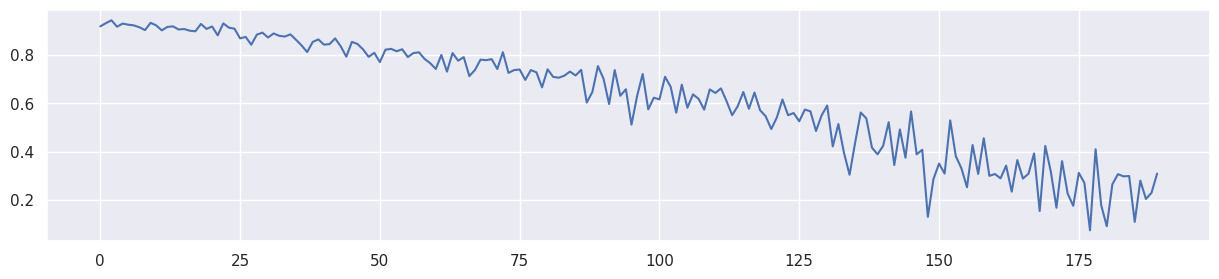

Mean R2 for all data: 0.6248819777468051
[Lambda: 0.100000] [Epoch 0/4000] [mi loss: 0.024451] [G loss: 0.000005]
[Lambda: 0.100000] [Epoch 200/4000] [mi loss: nan] [G loss: 0.000005]
[Lambda: 0.100000] [Epoch 400/4000] [mi loss: nan] [G loss: 0.000003]
[Lambda: 0.100000] [Epoch 600/4000] [mi loss: nan] [G loss: 0.000002]
[Lambda: 0.100000] [Epoch 800/4000] [mi loss: nan] [G loss: 0.000001]
[Lambda: 0.100000] [Epoch 1000/4000] [mi loss: nan] [G loss: 0.000001]
[Lambda: 0.100000] [Epoch 1200/4000] [mi loss: nan] [G loss: 0.000001]
[Lambda: 0.100000] [Epoch 1400/4000] [mi loss: nan] [G loss: 0.000001]
[Lambda: 0.100000] [Epoch 1600/4000] [mi loss: nan] [G loss: 0.000001]
[Lambda: 0.100000] [Epoch 1800/4000] [mi loss: nan] [G loss: 0.000001]
[Lambda: 0.100000] [Epoch 2000/4000] [mi loss: nan] [G loss: 0.000000]
[Lambda: 0.100000] [Epoch 2200/4000] [mi loss: nan] [G loss: 0.000000]
[Lambda: 0.100000] [Epoch 2400/4000] [mi loss: nan] [G loss: 0.000000]
[Lambda: 0.100000] [Epoch 2600/4000] [

100%|██████████| 190/190 [00:00<00:00, 1463.74it/s]


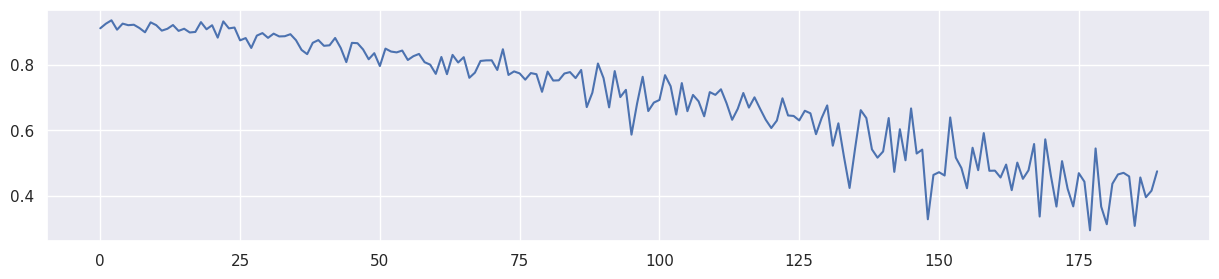

Mean R2 for all data: 0.6975142017307606
[Lambda: 0.200000] [Epoch 0/4000] [mi loss: 0.021734] [G loss: 0.000005]
[Lambda: 0.200000] [Epoch 200/4000] [mi loss: nan] [G loss: 0.000005]
[Lambda: 0.200000] [Epoch 400/4000] [mi loss: nan] [G loss: 0.000003]
[Lambda: 0.200000] [Epoch 600/4000] [mi loss: nan] [G loss: 0.000002]
[Lambda: 0.200000] [Epoch 800/4000] [mi loss: nan] [G loss: 0.000001]
[Lambda: 0.200000] [Epoch 1000/4000] [mi loss: nan] [G loss: 0.000001]
[Lambda: 0.200000] [Epoch 1200/4000] [mi loss: nan] [G loss: 0.000001]
[Lambda: 0.200000] [Epoch 1400/4000] [mi loss: nan] [G loss: 0.000001]
[Lambda: 0.200000] [Epoch 1600/4000] [mi loss: nan] [G loss: 0.000001]
[Lambda: 0.200000] [Epoch 1800/4000] [mi loss: nan] [G loss: 0.000001]
[Lambda: 0.200000] [Epoch 2000/4000] [mi loss: nan] [G loss: 0.000000]
[Lambda: 0.200000] [Epoch 2200/4000] [mi loss: nan] [G loss: 0.000000]
[Lambda: 0.200000] [Epoch 2400/4000] [mi loss: nan] [G loss: 0.000000]
[Lambda: 0.200000] [Epoch 2600/4000] [

100%|██████████| 190/190 [00:00<00:00, 1426.95it/s]


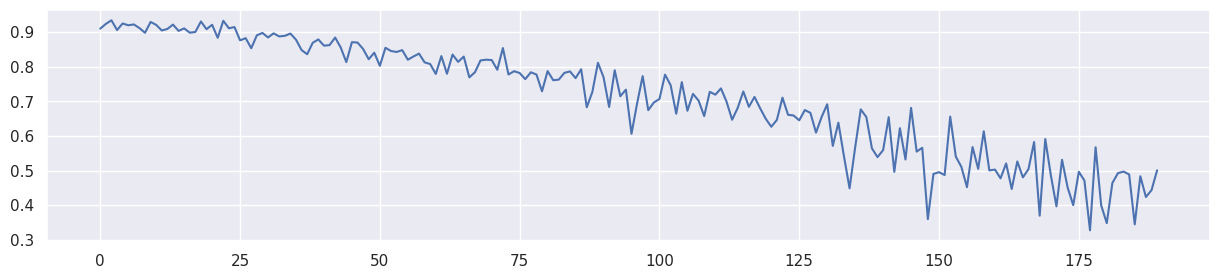

Mean R2 for all data: 0.7104761467270788
[Lambda: 0.300000] [Epoch 0/4000] [mi loss: 0.020617] [G loss: 0.000005]
[Lambda: 0.300000] [Epoch 200/4000] [mi loss: nan] [G loss: 0.000005]
[Lambda: 0.300000] [Epoch 400/4000] [mi loss: nan] [G loss: 0.000003]
[Lambda: 0.300000] [Epoch 600/4000] [mi loss: nan] [G loss: 0.000002]
[Lambda: 0.300000] [Epoch 800/4000] [mi loss: nan] [G loss: 0.000002]
[Lambda: 0.300000] [Epoch 1000/4000] [mi loss: nan] [G loss: 0.000001]
[Lambda: 0.300000] [Epoch 1200/4000] [mi loss: nan] [G loss: 0.000001]
[Lambda: 0.300000] [Epoch 1400/4000] [mi loss: nan] [G loss: 0.000001]
[Lambda: 0.300000] [Epoch 1600/4000] [mi loss: nan] [G loss: 0.000001]
[Lambda: 0.300000] [Epoch 1800/4000] [mi loss: nan] [G loss: 0.000001]
[Lambda: 0.300000] [Epoch 2000/4000] [mi loss: nan] [G loss: 0.000001]
[Lambda: 0.300000] [Epoch 2200/4000] [mi loss: nan] [G loss: 0.000000]
[Lambda: 0.300000] [Epoch 2400/4000] [mi loss: nan] [G loss: 0.000000]
[Lambda: 0.300000] [Epoch 2600/4000] [

100%|██████████| 190/190 [00:00<00:00, 1448.44it/s]


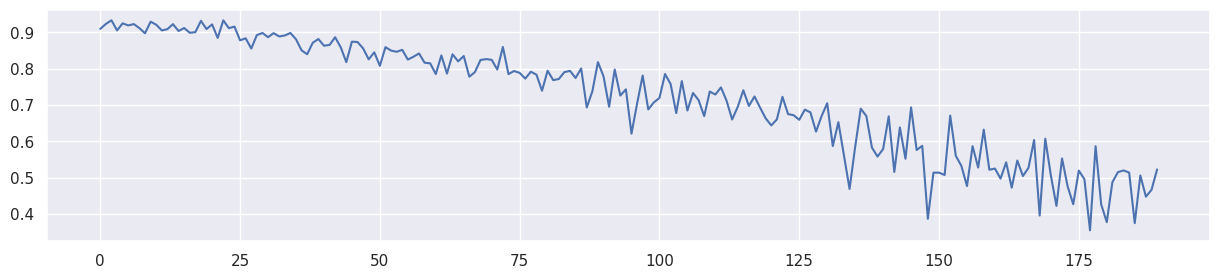

Mean R2 for all data: 0.7213371584002112
[Lambda: 0.400000] [Epoch 0/4000] [mi loss: 0.025097] [G loss: 0.000005]
[Lambda: 0.400000] [Epoch 200/4000] [mi loss: nan] [G loss: 0.000005]
[Lambda: 0.400000] [Epoch 400/4000] [mi loss: nan] [G loss: 0.000003]
[Lambda: 0.400000] [Epoch 600/4000] [mi loss: nan] [G loss: 0.000002]
[Lambda: 0.400000] [Epoch 800/4000] [mi loss: nan] [G loss: 0.000002]
[Lambda: 0.400000] [Epoch 1000/4000] [mi loss: nan] [G loss: 0.000001]
[Lambda: 0.400000] [Epoch 1200/4000] [mi loss: nan] [G loss: 0.000001]
[Lambda: 0.400000] [Epoch 1400/4000] [mi loss: nan] [G loss: 0.000001]
[Lambda: 0.400000] [Epoch 1600/4000] [mi loss: nan] [G loss: 0.000001]
[Lambda: 0.400000] [Epoch 1800/4000] [mi loss: nan] [G loss: 0.000001]
[Lambda: 0.400000] [Epoch 2000/4000] [mi loss: nan] [G loss: 0.000001]
[Lambda: 0.400000] [Epoch 2200/4000] [mi loss: nan] [G loss: 0.000000]
[Lambda: 0.400000] [Epoch 2400/4000] [mi loss: nan] [G loss: 0.000000]
[Lambda: 0.400000] [Epoch 2600/4000] [

100%|██████████| 190/190 [00:00<00:00, 1425.50it/s]


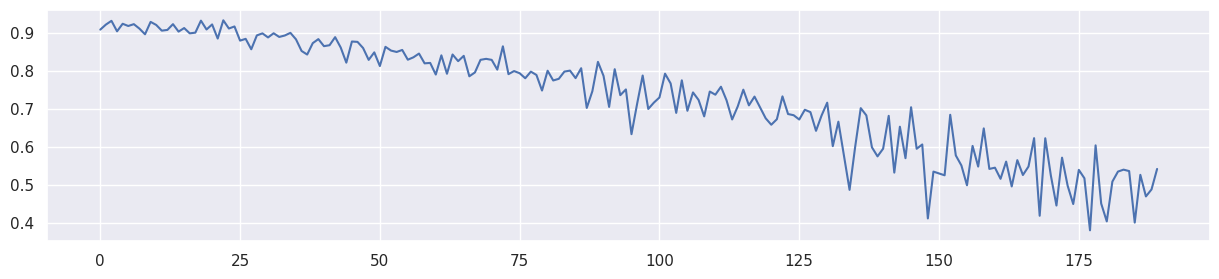

Mean R2 for all data: 0.7304586807671536
[Lambda: 0.500000] [Epoch 0/4000] [mi loss: 0.023910] [G loss: 0.000005]
[Lambda: 0.500000] [Epoch 200/4000] [mi loss: nan] [G loss: 0.000005]
[Lambda: 0.500000] [Epoch 400/4000] [mi loss: nan] [G loss: 0.000003]
[Lambda: 0.500000] [Epoch 600/4000] [mi loss: nan] [G loss: 0.000002]
[Lambda: 0.500000] [Epoch 800/4000] [mi loss: nan] [G loss: 0.000002]
[Lambda: 0.500000] [Epoch 1000/4000] [mi loss: nan] [G loss: 0.000001]
[Lambda: 0.500000] [Epoch 1200/4000] [mi loss: nan] [G loss: 0.000001]
[Lambda: 0.500000] [Epoch 1400/4000] [mi loss: nan] [G loss: 0.000001]
[Lambda: 0.500000] [Epoch 1600/4000] [mi loss: nan] [G loss: 0.000001]
[Lambda: 0.500000] [Epoch 1800/4000] [mi loss: nan] [G loss: 0.000001]
[Lambda: 0.500000] [Epoch 2000/4000] [mi loss: nan] [G loss: 0.000001]
[Lambda: 0.500000] [Epoch 2200/4000] [mi loss: nan] [G loss: 0.000000]
[Lambda: 0.500000] [Epoch 2400/4000] [mi loss: nan] [G loss: 0.000000]
[Lambda: 0.500000] [Epoch 2600/4000] [

100%|██████████| 190/190 [00:00<00:00, 1471.44it/s]


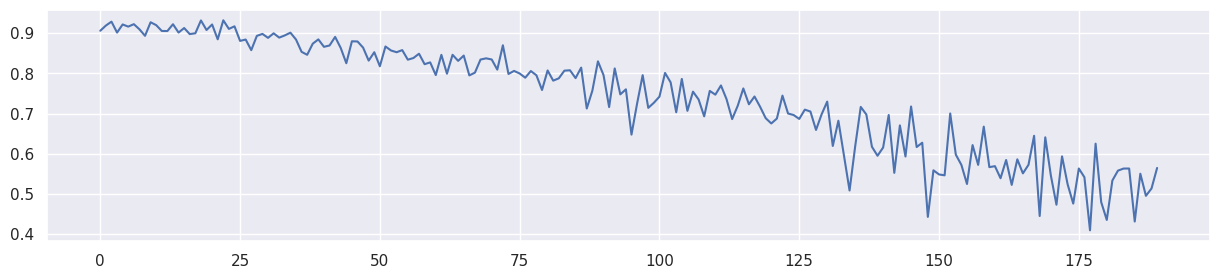

Mean R2 for all data: 0.7418325894146072
[Lambda: 0.600000] [Epoch 0/4000] [mi loss: 0.021301] [G loss: 0.000005]
[Lambda: 0.600000] [Epoch 200/4000] [mi loss: nan] [G loss: 0.000005]
[Lambda: 0.600000] [Epoch 400/4000] [mi loss: nan] [G loss: 0.000003]
[Lambda: 0.600000] [Epoch 600/4000] [mi loss: nan] [G loss: 0.000002]
[Lambda: 0.600000] [Epoch 800/4000] [mi loss: nan] [G loss: 0.000002]
[Lambda: 0.600000] [Epoch 1000/4000] [mi loss: nan] [G loss: 0.000001]
[Lambda: 0.600000] [Epoch 1200/4000] [mi loss: nan] [G loss: 0.000001]
[Lambda: 0.600000] [Epoch 1400/4000] [mi loss: nan] [G loss: 0.000001]
[Lambda: 0.600000] [Epoch 1600/4000] [mi loss: nan] [G loss: 0.000001]
[Lambda: 0.600000] [Epoch 1800/4000] [mi loss: nan] [G loss: 0.000001]
[Lambda: 0.600000] [Epoch 2000/4000] [mi loss: nan] [G loss: 0.000001]
[Lambda: 0.600000] [Epoch 2200/4000] [mi loss: nan] [G loss: 0.000001]
[Lambda: 0.600000] [Epoch 2400/4000] [mi loss: nan] [G loss: 0.000000]
[Lambda: 0.600000] [Epoch 2600/4000] [

100%|██████████| 190/190 [00:00<00:00, 1196.35it/s]


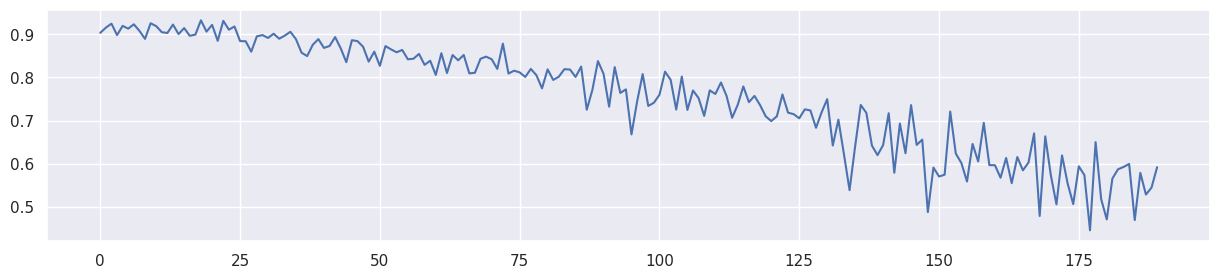

Mean R2 for all data: 0.7569187566726983
[Lambda: 0.700000] [Epoch 0/4000] [mi loss: 0.025309] [G loss: 0.000005]
[Lambda: 0.700000] [Epoch 200/4000] [mi loss: nan] [G loss: 0.000005]
[Lambda: 0.700000] [Epoch 400/4000] [mi loss: nan] [G loss: 0.000003]
[Lambda: 0.700000] [Epoch 600/4000] [mi loss: nan] [G loss: 0.000002]
[Lambda: 0.700000] [Epoch 800/4000] [mi loss: nan] [G loss: 0.000002]
[Lambda: 0.700000] [Epoch 1000/4000] [mi loss: nan] [G loss: 0.000001]
[Lambda: 0.700000] [Epoch 1200/4000] [mi loss: nan] [G loss: 0.000001]
[Lambda: 0.700000] [Epoch 1400/4000] [mi loss: nan] [G loss: 0.000001]
[Lambda: 0.700000] [Epoch 1600/4000] [mi loss: nan] [G loss: 0.000001]
[Lambda: 0.700000] [Epoch 1800/4000] [mi loss: nan] [G loss: 0.000001]
[Lambda: 0.700000] [Epoch 2000/4000] [mi loss: nan] [G loss: 0.000001]
[Lambda: 0.700000] [Epoch 2200/4000] [mi loss: nan] [G loss: 0.000001]
[Lambda: 0.700000] [Epoch 2400/4000] [mi loss: nan] [G loss: 0.000000]
[Lambda: 0.700000] [Epoch 2600/4000] [

100%|██████████| 190/190 [00:00<00:00, 1363.26it/s]


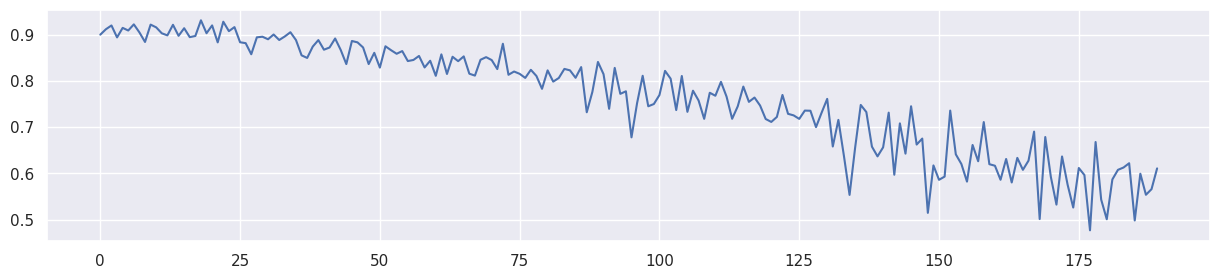

Mean R2 for all data: 0.7653325953958636
[Lambda: 0.800000] [Epoch 0/4000] [mi loss: 0.023621] [G loss: 0.000005]
[Lambda: 0.800000] [Epoch 200/4000] [mi loss: nan] [G loss: 0.000005]
[Lambda: 0.800000] [Epoch 400/4000] [mi loss: nan] [G loss: 0.000004]
[Lambda: 0.800000] [Epoch 600/4000] [mi loss: nan] [G loss: 0.000002]
[Lambda: 0.800000] [Epoch 800/4000] [mi loss: nan] [G loss: 0.000002]
[Lambda: 0.800000] [Epoch 1000/4000] [mi loss: nan] [G loss: 0.000001]
[Lambda: 0.800000] [Epoch 1200/4000] [mi loss: nan] [G loss: 0.000001]
[Lambda: 0.800000] [Epoch 1400/4000] [mi loss: nan] [G loss: 0.000001]
[Lambda: 0.800000] [Epoch 1600/4000] [mi loss: nan] [G loss: 0.000001]
[Lambda: 0.800000] [Epoch 1800/4000] [mi loss: nan] [G loss: 0.000001]
[Lambda: 0.800000] [Epoch 2000/4000] [mi loss: nan] [G loss: 0.000001]
[Lambda: 0.800000] [Epoch 2200/4000] [mi loss: nan] [G loss: 0.000001]
[Lambda: 0.800000] [Epoch 2400/4000] [mi loss: nan] [G loss: 0.000001]
[Lambda: 0.800000] [Epoch 2600/4000] [

100%|██████████| 190/190 [00:00<00:00, 1330.10it/s]


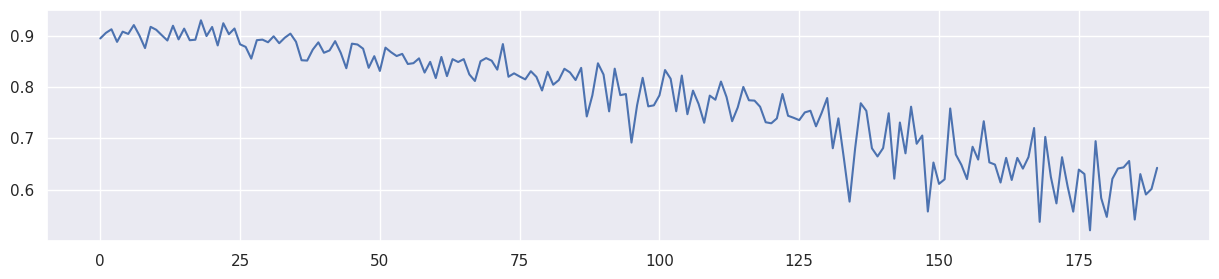

Mean R2 for all data: 0.7774116916493596
[Lambda: 0.900000] [Epoch 0/4000] [mi loss: 0.024809] [G loss: 0.000005]
[Lambda: 0.900000] [Epoch 200/4000] [mi loss: nan] [G loss: 0.000005]
[Lambda: 0.900000] [Epoch 400/4000] [mi loss: nan] [G loss: 0.000004]
[Lambda: 0.900000] [Epoch 600/4000] [mi loss: nan] [G loss: 0.000003]
[Lambda: 0.900000] [Epoch 800/4000] [mi loss: nan] [G loss: 0.000002]
[Lambda: 0.900000] [Epoch 1000/4000] [mi loss: nan] [G loss: 0.000002]
[Lambda: 0.900000] [Epoch 1200/4000] [mi loss: nan] [G loss: 0.000001]
[Lambda: 0.900000] [Epoch 1400/4000] [mi loss: nan] [G loss: 0.000001]
[Lambda: 0.900000] [Epoch 1600/4000] [mi loss: nan] [G loss: 0.000001]
[Lambda: 0.900000] [Epoch 1800/4000] [mi loss: nan] [G loss: 0.000001]
[Lambda: 0.900000] [Epoch 2000/4000] [mi loss: nan] [G loss: 0.000001]
[Lambda: 0.900000] [Epoch 2200/4000] [mi loss: nan] [G loss: 0.000001]
[Lambda: 0.900000] [Epoch 2400/4000] [mi loss: nan] [G loss: 0.000001]
[Lambda: 0.900000] [Epoch 2600/4000] [

100%|██████████| 190/190 [00:00<00:00, 1390.53it/s]


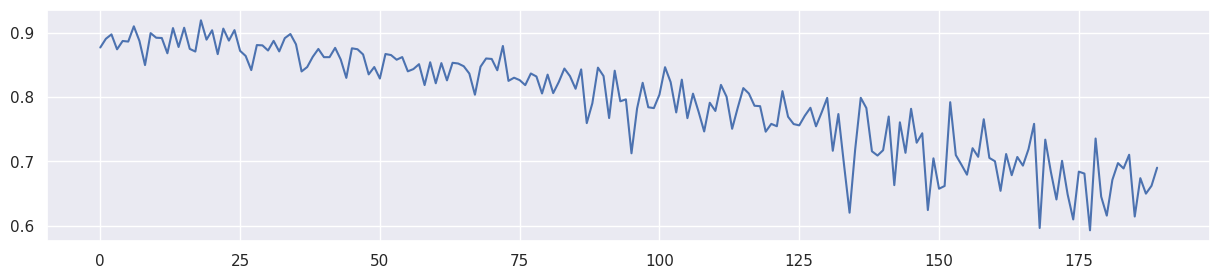

Mean R2 for all data: 0.7931574144528262


,lambda,test_r2,init_r2,mean_r2,last_r2,"MI(y^,z)"
0,0.0,0.932139,0.918649,0.624882,0.309793,1.223229
1,0.1,0.922493,0.911268,0.697514,0.474939,1.122792
2,0.2,0.920804,0.910243,0.710476,0.500974,1.095603
3,0.3,0.919079,0.909454,0.721337,0.523053,1.062029
4,0.4,0.917004,0.908183,0.730459,0.541622,1.053067
5,0.5,0.914006,0.906091,0.741833,0.564927,1.029883
6,0.6,0.908919,0.903486,0.756919,0.592251,0.987331
7,0.7,0.904136,0.900588,0.765333,0.610749,1.006039
8,0.8,0.894681,0.894263,0.777412,0.642402,1.021050
9,0.9,0.870034,0.877647,0.793157,0.690198,0.974088


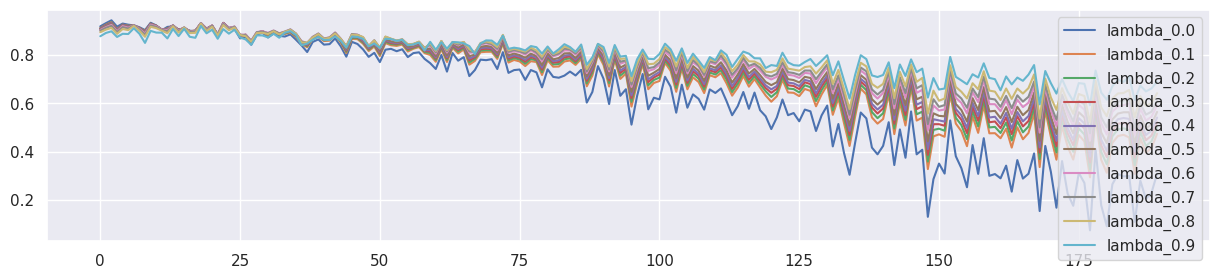

In [110]:
seed_everything()

train_result = []
train_tensors = Namespace(XS_train = torch.tensor(X[0:1800][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                          y_train = torch.tensor(y[0:1800], dtype=torch.float32),
                          s1_train = torch.tensor(X[0:1800][['z0']].values, dtype=torch.float32))
test_tensors = Namespace(XS_test = torch.tensor(X[1800:2000][['x0','x1','x2','x3','z0']].values, dtype=torch.float32),
                         y_test = torch.tensor(y[1800:2000], dtype=torch.float32),
                         s1_test = torch.tensor(X[1800:2000][['z0']].values, dtype=torch.float32))

train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)
seed = 1

lambda_f_set = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] # Lambda value for the fairness discriminator of FR-Train.
#lambda_r = 0.4 # Lambda value for the robustness discriminator of FR-Train.

result_table = {}
result_table2 = {}
result_table2['lambda']=[]
result_table2['test_r2']=[]
result_table2['init_r2']=[]
result_table2['mean_r2']=[]
result_table2['last_r2']=[]
result_table2['MI(y^,z)']=[]

for lambda_f in lambda_f_set:
    if lambda_f == 0.0:
        r2,mi,last_generator= train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed)
        result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator)
    else:
        r2,mi,last_generator= train_model3(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, seed = seed)
        result_table[f'lambda_{lambda_f}'] = test_all_data(last_generator)

    result_table2['lambda'].append(lambda_f)
    result_table2['test_r2'].append(r2)
    result_table2['init_r2'].append(result_table[f'lambda_{lambda_f}'][0])
    result_table2['mean_r2'].append(np.mean(result_table[f'lambda_{lambda_f}']))
    result_table2['last_r2'].append(result_table[f'lambda_{lambda_f}'][-1])
    result_table2['MI(y^,z)'].append(mi)

result_df = pd.DataFrame(result_table)
result_df.plot(figsize=(15,3))

result2_df = pd.DataFrame(result_table2)
result2_df